### Final Report

#### Name: Gustavo Bartholomeu Trad Souza
#### Nº USP: 11219216

### **Final proposal**
The final objective of the project is to create bounding boxes arround the text present in still images. Before identifying the text regions, the image is passed to image enhancement functions so that texts in noisy images, that could not be identified before the enhancement, will now be identified. First image enhancement techniques are applyed in the image in order to reduce the noise in the image, the next step is to apply debluring thechniques to improve the image quality and then the image is fed to the network and the text presence information is acquired and used to draw the bounding boxes around the text.

## **Metodology**
The techniques used in the enhancement step are:

 * **Median Filter:** Apply a filter of shape k x k in the image where the resulting pixel is the median of the neighborhood pixels. This filter aims to reduce the noise present in the image by reducing the variance between a pixel and its neighbourhood.
  
 * **Bilateral Filter:** Apply a nonlinear filter to smooth images while preserving edges. This filter aims to reduce the noise and preserve the text edges
 
 * **Unsharp mask using the Laplacian Filter:** The unsharp mask filtering is a sharpening technique that subtracts an unsharp or blurred version of an image from the original image. The objective of this technique is to enhance edges and transitions of intensities.

After the enhancement techniques the image is passed trough a debluring function that aims to improve the image quality and make the text easier to detect.
Next the image is fed to a neural network that outputs as its final layers the information about the presence of text in a given region and the distance of that region to the limits of the bounding box containig it. With this information the bounding boxes are obtained for the regions where text was found.

## **Conclusion**
The objective of the project was reached. After applying the enhancement techniques, the text in noisy images was more easily detected, the notebook in the repository shows the code used and a example with a comparison between an modified image and a unmodifie image.

In [1]:
# import the necessary packages
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def medianFilter(g, k):
    ''' Apply a filter of shape k x k in the image where the resulting pixel is the median of the neighborhood pixels. 
    This filter aims to reduce the noise present in the image by reducing the variance between a pixel and its neighbourhood.
    '''
    g = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
    a = k//2
    r = np.zeros(g.shape)
    for x in np.arange(a, g.shape[0]-a+1):
        for y in np.arange(a, g.shape[1]-a+1):
            med_region = np.median(g[x-a:x+a+1, y-a:y+a+1])
            r[x,y] = med_region
    r = normalization(r)
    r = cv2.cvtColor(g, cv2.COLOR_GRAY2BGR)
    return r

#---------------------------------------------------------------------------------------------    
def unsharpLap(img, c=0.5, k_opt=1):
    '''
    The unsharp mask filtering is a sharpening technique that subtracts an unsharp or blurred version of an image from the original image. 
    The objective of this technique is to enhance edges and transitions of intensities.
    '''
    #Select the Laplacian filter
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if(k_opt == 1):
        w = np.matrix([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]).astype(np.float)
    elif(k_opt == 2):
        w = np.matrix([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]).astype(np.float)
    #--------------------------------------------   
    #OUTPUT IMAGE CREATION
    n = np.shape(w)[0]
    a = int((n-1)/2)
    #Get the dimensions of the original image
    N,M = img.shape
    # new image to store filtered pixels
    g_out = np.zeros(img.shape)
    #Create the new image with zeros and copy the original image but with zero padding
    g = np.zeros((N+(a*2), M+(a*2)))
    i = 0
    for x in range(a, np.shape(g)[0] - a):
        j = 0
        for y in range(a, np.shape(g)[1] - a):
            g[x, y] = img[i, j]
            j += 1
        i += 1
    #--------------------------------------------  
    #CONVOLUTION
    w = np.flip( np.flip(w, 0) , 1)
    for x in range(N):
        for y in range(M):
            sub_f = g[x : x+n , y : y+n]
            g_out[x,y] = np.sum( np.multiply(sub_f, w))
            
    g_out = normalization(g_out)
    g_out = np.add((c * g_out), img)
    g_out = normalization(g_out).astype(np.uint8)
    g_out = cv2.cvtColor(g_out, cv2.COLOR_GRAY2BGR)
    return g_out
#---------------------------------------------------------------------------------------------    
#Normalization function
def normalization(img, val = 255):
    img = img.astype(np.float)
    amax, amin = np.amax(img), np.amin(img)
    return ((img - amin)/(amax - amin))*val
#---------------------------------------------------------------------------------------------    
#Method 1 - Bilateral Filter
def bilateral(img, n=5, ts=50, tr=100):
    '''
    Apply a nonlinear filter to smooth images while preserving edges. 
    This filter aims to reduce the noise and preserve the text edges
    '''
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #FILTER CREATION
    #Create a zeros matrix with the size of the filter
    w = np.zeros((n, n))
    #Get the center index of the filter
    a = int((n-1)/2)
    #Genearte the values on the filter based on the spatial Gaussian component
    for i in range(n):
        for j in range(n):
            #E = sqrt(x² + y²)
            E = np.sqrt(float((i - a)**2) + float((j - a)**2))
            #E = ((i - a)**2) + ((j - a)**2)
            w[i, j] = gausKernel(E, ts)
    # flipped filter
    w = np.flip( np.flip(w, 0) , 1)
    #--------------------------------------------
    #OUTPUT IMAGE CREATION
    #Get the dimensions of the original image
    N,M = img.shape
    # new image to store filtered pixels
    g_out = np.zeros(img.shape)
    #Create the new image with zeros and copy the original image but with zero padding
    g = np.zeros((N+(a*2), M+(a*2)))
    i = 0
    for x in range(a, np.shape(g)[0] - a):
        j = 0
        for y in range(a, np.shape(g)[1] - a):
            g[x, y] = img[i, j]
            j += 1
        i += 1
    #--------------------------------------------
    #CONVOLUTION PROCESS
    # for every pixel
    for x in range(N):
        for y in range(M):
            If, Wp = 0, 0
            # gets subimage
            sub_f = g[x : x+n , y : y+n]
            #Get the value of the center pixel of the sub image
            I = sub_f[a, a]
            for i in range(np.shape(sub_f)[0]):
                for j in range(np.shape(sub_f)[1]):
                    gri = gausKernel(sub_f[i, j] - I, tr)
                    wi = gri * w[i , j]
                    Wp = Wp + wi
                    If += (wi * sub_f[i, j])
            If /= Wp
            g_out[x, y] = If
    g_out = g_out.astype(np.uint8)
    g_out = cv2.cvtColor(g_out, cv2.COLOR_GRAY2BGR)              
    return g_out
#---------------------------------------------------------------------------------------------
#Gaussian Kernel formula for a given x and a theta t
def gausKernel(x, t):
    return ((1 / (2 * np.pi * (t**2))) * np.exp(-((x**2) / (2 * (t**2)))))

In [3]:
#Function to create a gaussian filter of dimensions=[k, k] and variance=sigma
def gaussian_filter(k=3, sigma=1.0):
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp( -(1/2)*(np.square(x) + np.square(y))/np.square(sigma) )
    
    return filt/np.sum(filt)

#Denoising an image 'img' with a gaussian filter 'h'
def denoise(img, k, sigma):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Padd the filter
    h = gaussian_filter(k=k, sigma=sigma)
    
    #Padding the gaussian filter
    a = int(img.shape[0]//2 - h.shape[0]//2)
    b = int(img.shape[1]//2 - h.shape[1]//2)
    if(k%2 == 0):
        h_pad = np.pad(h, ((a, a), (b, b)), 'constant', constant_values=(0))
    else:
        h_pad = np.pad(h, ((a, a-1), (b, b-1)), 'constant', constant_values=(0))
    
    #Get the FFTs of the image and filter
    G = np.fft.fftn(img)
    H = np.fft.fftn(h_pad)
    
    #Denoising in the frequency domain
    F = np.multiply(G, H)
    
    #Getting the denoised image
    f = np.fft.fftshift(np.fft.ifftn(F).real)
    
    #Normalizing f between [0, maxg]
    amin = np.amin(f)
    amax = np.amax(f)
    f = ( (f - amin)/(amax - amin) )*np.amax(img)
    
    f = f.astype(np.uint8)
    f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR) 
    
    return f

#Deblur the image 'img' with a gaussian filter 'h' and a Laplacian operator 'p'
def deblur(img, k, sigma, gamma):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #padding the Laplacian operator
    
    h = gaussian_filter(k=k, sigma=sigma)
    p = np.matrix([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    
    #padding the Laplacian operator
    a = int(img.shape[0]//2 - p.shape[0]//2)
    b = int(img.shape[1]//2 - p.shape[1]//2)
    p_pad = np.pad(p, ((a, a-1), (b, b-1)), 'constant', constant_values=(0))
    
    #Padding the gaussian filter
    a = int(img.shape[0]//2 - h.shape[0]//2)
    b = int(img.shape[1]//2 - h.shape[1]//2)
    if(k%2 == 0):
        h_pad = np.pad(h, ((a,a), (b, b)), 'constant', constant_values=(0))
    else:
        h_pad = np.pad(h, ((a,a-1), (b, b-1)), 'constant', constant_values=(0))
    
    #Computing the FFTs of the Laplacian operator, image and filter
    P = np.fft.fftn(p_pad)
    G = np.fft.fftn(img)
    H = np.fft.fftn(h_pad)
    
    #Apply the debluring process on the frequency domain
    F = np.multiply(( np.conj(H)/((np.abs(H)**2)+gamma*(np.abs(P)**2))), G)

    #Get the deblured image
    f = np.fft.fftshift(np.fft.ifftn(F).real)

    #Normalizing f between [0, maxg]
    amin = np.amin(f)
    amax = np.amax(f)
    f = ( (f - amin)/(amax - amin) )*np.amax(img)
    
    f = f.astype(np.uint8)
    f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR) 
    
    return f

In [4]:
#Path to the image
image_path = "images/text_4.png"
#The EAST scene text detector pre-trained model file path.
net_path = "frozen_east_text_detection.pb"
#Enhance and deblur options
do_enhance = True
do_deblur = False
#Size of the kernel
k = 5
#Bilateral fulter parameters
ts = 100
tr = 200
#Unsharp mask parameters
c = 0.6
k_opt = 1
#Deblur parameters
sigma = 2.5
gamma = 0.0001
#Probability threshold to determine presence of text.
min_confidence = 0.4

(-0.5, 223.5, 255.5, -0.5)

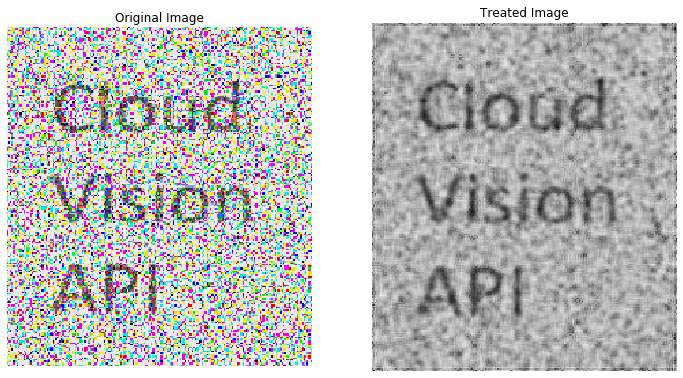

In [5]:
# load the input image and grab the image dimensions
image_aux = cv2.imread(image_path)
orig = image_aux.copy()
orig_copy = image_aux.copy()

(H, W) = image_aux.shape[:2]

#The input for the network must be a multiple of 32
#Set the new width and height to the upper closest multiple of 32 of both original dimensions
(newW, newH) = ( ((W//32)+1)*32, ((H//32)+1)*32 )

#determine the ratio between the original and the new values
ratio_W = W/float(newW)
ratio_H = H/float(newH)

# resize the image and grab the new image dimensions
image_aux = cv2.resize(image_aux, (newW, newH))
(H, W) = (newH, newW)

#Copy the image before the enhancement techiniques
image_aux_orig = image_aux.copy()

#Apply the enhancement functions in the image
if do_enhance:
    image_aux = medianFilter(image_aux, k)
    image_aux = bilateral(image_aux, k, ts, tr)
    image_aux = unsharpLap(image_aux, c, k_opt)

#Apply the deblur function in the image
if do_deblur: 
    image_aux = deblur(image_aux, k, sigma, gamma)


#Transform the color schema from BGR to RGB
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Treated Image")
plt.imshow(image_aux)
plt.axis('off')

In [6]:
#Load the pre-trained EAST text detector
net = cv2.dnn.readNet(net_path)

#Print all the layers names of the model
all_layers = net.getLayerNames()
#for i in range(len(all_layers)):
#    print(str(i)+":\t"+all_layers[i])
    
#Define the layers that the output will be analysed

#The layer that outputs the probabilities of text in each 4x4 region of the original image (the last layer)
out_prob = all_layers[-1]
#The layer used to derive the bounding box coordinates of text
bound_box = all_layers[-3]
#Create the list with the layers names
layer_names = [out_prob, bound_box]

scores dim: (1, 1, 64, 56)
geometry dim: (1, 5, 64, 56)


(-0.5, 55.5, 63.5, -0.5)

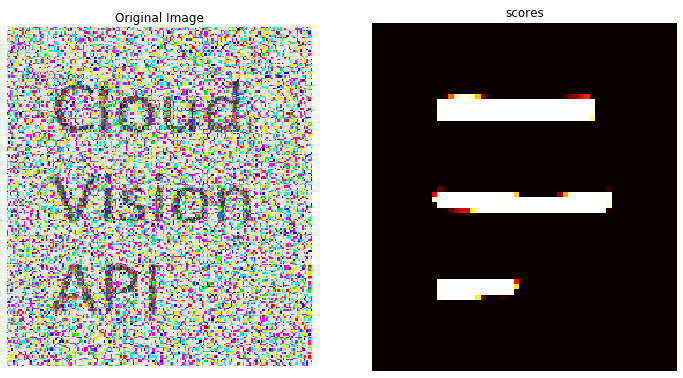

In [7]:
#Reshape from (Hight, Width, Chanels) to (1, Chanels, Hight, Width) -> The net input shape
image = np.array([image_aux[:, :, 0], image_aux[:, :, 1], image_aux[:, :, 2]])
image_aux_orig = np.array([image_aux_orig[:, :, 0], image_aux_orig[:, :, 1], image_aux_orig[:, :, 2]])

image = image[np.newaxis, :]
image_aux_orig = image_aux_orig[np.newaxis, :]

#Perform a forward pass of the model and obtain the two output layer sets by passing the image as input
net.setInput(image)
(scores, geometry) = net.forward(layer_names)
#scores->Probability of text in the regions
#geometry->Bounding boxes geometry information

#Do the same for the unchanged image
net.setInput(image_aux_orig)
(scores_orig, geometry_orig) = net.forward(layer_names)

print("scores dim: "+str(np.shape(scores)))
print("geometry dim: "+str(np.shape(geometry)))

plt.figure(figsize=(12,12))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("scores")
plt.imshow(np.squeeze(scores), cmap='hot')
plt.axis('off')

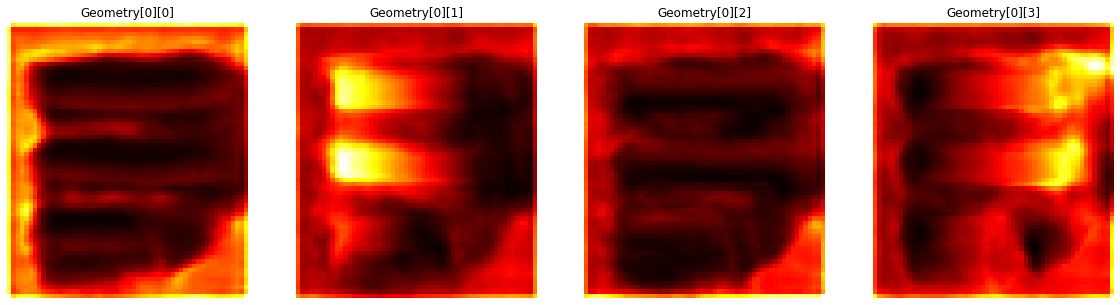

In [8]:
#Geometry information chanels
plt.figure(figsize=(25,25))
for layer in range(len(geometry[0][:-1])):
    plt.subplot(1, len(geometry[0]), layer+1)
    plt.title("Geometry[0]["+str(layer)+"]")
    plt.imshow(geometry[0][layer], cmap='hot')
    plt.axis('off')

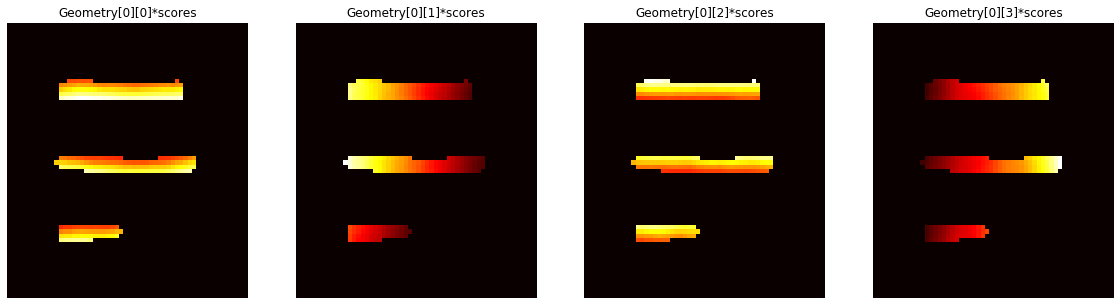

In [9]:
#Geometry informations where the scores are greater than or equal the minimum confidence bound
plt.figure(figsize=(25,25))
for layer in range(len(geometry[0][:-1])):
    plt.subplot(1, len(geometry[0]), layer+1)
    plt.title("Geometry[0]["+str(layer)+"]*scores")
    btl_scores = np.ones(np.shape(scores))
    btl_scores[np.where(scores < min_confidence)] = 0
    plt.imshow(geometry[0][layer]*np.squeeze(btl_scores), cmap='hot')
    plt.axis('off')

In [10]:
#Grab the number of rows and columns from the scores volume, then initialize our set of bounding box 
#    rectangles and corresponding confidence scores
(num_rows, num_cols) = scores.shape[-2:]
rects = []
rects_orig = []
confidences = []
confidences_orig=[]

#Loop over the number of rows in the layers outputs
for y in range(num_rows):
    #Extract the scores (probabilities), followed by the geometrical data used to derive potential 
    #    bounding box coordinates that surround text. 
    #Each one of the four chanels indicate the distance of the pixel being analysed to the limits of the boxes
    #Probability of text in that region
    scoresData = scores[0, 0, y]
    scoresData_orig = scores_orig[0, 0, y]
    #Distance between the pixel and the upper limit of the boxes
    dist_to_top = geometry[0, 0, y]
    dist_to_top_orig = geometry_orig[0, 0, y]
    #Distance between the pixel and the right limit of the boxes
    dist_to_right = geometry[0, 1, y]
    dist_to_right_orig = geometry_orig[0, 1, y]
    #Distance between the pixel and the lower limit of the boxes
    dist_to_down = geometry[0, 2, y]
    dist_to_down_orig = geometry_orig[0, 2, y]
    #Distance between the pixel and the left limit of the boxes
    dist_to_left = geometry[0, 3, y]
    dist_to_left_orig = geometry_orig[0, 3, y]
    
    #Loop over the number of columns
    for x in range(num_cols):
        #Ignore weak text probability
        if scoresData[x] >= min_confidence:
            #Compute the offset factor (The reduction factor between the input image and the output layers)
            offsetX = x*(np.shape(image)[-2]/np.shape(scores)[-2])
            offsetY = y*(np.shape(image)[-1]/np.shape(scores)[-1])
            #Use the geometry information to derive the width and height of the bounding box
            h = int(dist_to_top[x] + dist_to_down[x])
            w = int(dist_to_right[x] + dist_to_left[x])
            #Compute both the starting (x, y)-coordinates for the text prediction bounding box
            x_init = int(int(offsetX + dist_to_right[x]) - w)
            y_init = int(int(offsetY + dist_to_down[x]) - h)
            #Add the bounding box coordinates and probability score to our respective lists
            rects.append([x_init, y_init, w, h])
            confidences.append(float(scoresData[x]))
        
        #Ignore weak text probability
        if scoresData_orig[x] >= min_confidence:
            #Compute the offset factor (The reduction factor between the input image and the output layers) 
            offsetX_orig = x*(np.shape(image_aux_orig)[-2]/np.shape(scores_orig)[-2])
            offsetY_orig = y*(np.shape(image_aux_orig)[-1]/np.shape(scores_orig)[-1])
            #Use the geometry information to derive the width and height of the bounding box
            h = int(dist_to_top_orig[x] + dist_to_down_orig[x])
            w = int(dist_to_right_orig[x] + dist_to_left_orig[x])
            #Compute both the starting (x, y)-coordinates for the text prediction bounding box
            x_init_orig = int(int(offsetX_orig + dist_to_right_orig[x]) - w)
            y_init_orig = int(int(offsetY_orig + dist_to_down_orig[x]) - h)
            #Add the bounding box coordinates and probability score to our respective lists
            rects_orig.append([x_init_orig, y_init_orig, w, h])
            confidences_orig.append(float(scoresData[x]))

(-0.5, 220.5, 245.5, -0.5)

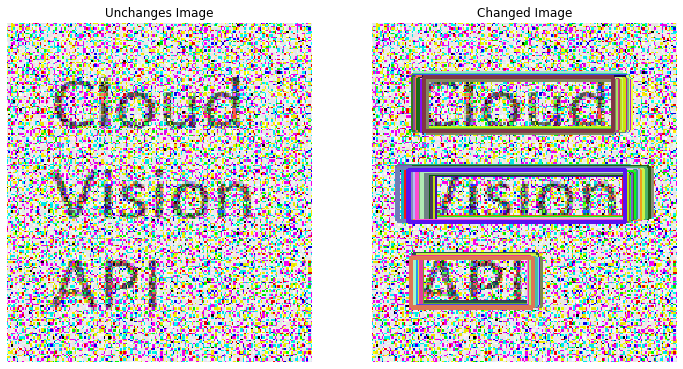

In [11]:
orig_boxes = orig.copy()
orig_boxes_aux = orig.copy()

#Loop over the bounding boxes indexes
for (x_init, y_init, w, h) in rects:
    #Scale the bounding box coordinates based on the respective ratios
    x_init = int(x_init * ratio_W)
    y_init = int(y_init * ratio_H)
    w = int(w * ratio_W)
    h = int(h * ratio_H)
    #Draw the bounding box on the image
    cv2.rectangle(orig_boxes, (x_init, y_init), (x_init + w, y_init + h), (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)), 2)
    
for (x_init, y_init, w, h) in rects_orig:
    #Scale the bounding box coordinates based on the respective ratios
    x_init = int(x_init * ratio_W)
    y_init = int(y_init * ratio_H)
    w = int(w * ratio_W)
    h = int(h * ratio_H)
    #Draw the bounding box on the image
    cv2.rectangle(orig_boxes_aux, (x_init, y_init), (x_init + w, y_init + h), (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)), 2)
    

plt.figure(figsize=(12,12))

plt.subplot(1, 2, 1)
plt.title("Unchanges Image")
plt.imshow(orig_boxes_aux)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Changed Image")
plt.imshow(orig_boxes)
plt.axis('off')

(-0.5, 220.5, 245.5, -0.5)

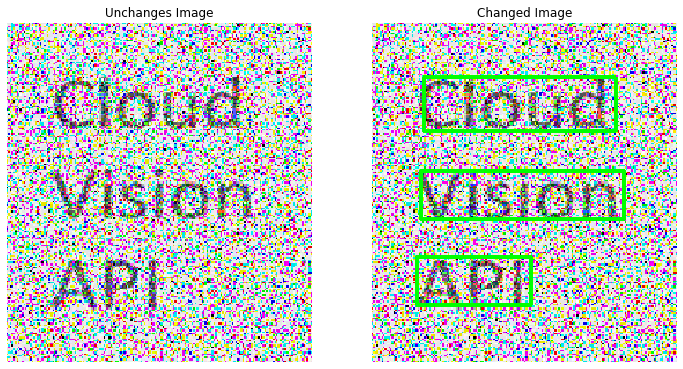

In [12]:
#Remove the overlaping lower confidence bounding boxes
box_index = cv2.dnn.NMSBoxes(bboxes=rects, scores=confidences, score_threshold=min_confidence, nms_threshold=min_confidence)
box_index_orig = cv2.dnn.NMSBoxes(bboxes=rects_orig, scores=confidences_orig, score_threshold=min_confidence, nms_threshold=min_confidence)

#Loop over the bounding boxes indexes
for i in box_index:
    x_init, y_init, w, h = rects[int(i)]
    #Scale the bounding box coordinates based on the respective ratios
    x_init = int(x_init * ratio_W)
    y_init = int(y_init * ratio_H)
    w = int(w * ratio_W)
    h = int(h * ratio_H)
    #Draw the bounding box on the image
    cv2.rectangle(orig, (x_init, y_init), (x_init + w, y_init + h), (0, 255, 0), 2)

for i in box_index_orig:
    x_init, y_init, w, h = rects_orig[int(i)]
    #Scale the bounding box coordinates based on the respective ratios
    x_init = int(x_init * ratio_W)
    y_init = int(y_init * ratio_H)
    w = int(w * ratio_W)
    h = int(h * ratio_H)
    #Draw the bounding box on the image
    cv2.rectangle(orig_copy, (x_init, y_init), (x_init + w, y_init + h), (0, 255, 0), 2)
    
plt.figure(figsize=(12,12))

plt.subplot(1, 2, 1)
plt.title("Unchanges Image")
plt.imshow(orig_copy)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Changed Image")
plt.imshow(orig)
plt.axis('off')